In [1]:
import os
from myutils import *
from sklearn.datasets import make_sparse_coded_signal
from sklearn.linear_model import OrthogonalMatchingPursuit
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = '4'
class Bump:
    def __init__(self, *args):
        if len(args) == 1:
            self.data_file = args[0]
        if len(args) == 2:
            folder = args[0]
            file   = args[1]
            self.data_file = os.path.join(folder, file)
        
    def load_data(self):
        self.df = import_transformer_data(self.data_file)
        
    def get_event(self, val:int, time:int):
        """get single pump events
        
        :param val: thre_val 
        :param time: thre_time
        :return: monotypeEvents, idx_monotype
        """
        self.event_duration, self.events_all = find_all_events(self.df, val, time)
        self.events_monotype,self.idx_monotype, self.events_other = find_monotype_events(self.events_all, val)
        self.events_monotype = [estimate_total_power(event_) for event_ in self.events_monotype]
            
        return self.events_monotype, self.idx_monotype
    
    def compute_features(self):
        self.feature, self.idx_used_events = compute_features_mono(self.events_monotype)
        self.feature.astype(np.float64)
        return self.feature, self.idx_used_events
    
    # def updated_feature_list(self, feature_list):
    #     self.feature = feature_list
    

    def kmeans_elbow(self, selected_feature=None, normal=False, max_iter=None, repeats=5):

        if selected_feature is None:
            selected_feature = ['ave. real power(ss)', 'ave. reactive power(ss)']
        self.grps, scores = kmeans_elbow(self.feature[selected_feature].values, normalize=normal,max_iter = max_iter, repeats = repeats)
        return self.grps, scores
    
    def matching_pursuit(self, thr_val=5, param_str='curnt_B', n_components=5, n_features=2, n_nonzero_coefs=5):
        event = self.events_other[8]
        signals = event[param_str].values
    
        # Find jump points in the signal
        idx_jump = np.where(np.abs(np.diff(signals)) > thr_val)[0]
        idx_jump = np.hstack((np.array([0]), idx_jump + 1, np.array([len(signals)])))
    
        nr_pluses = len(idx_jump) - 1
    
        # Compress the signal
        signals_compressed = np.zeros(nr_pluses)
        for i in range(nr_pluses):
            idx1 = idx_jump[i]
            idx2 = idx_jump[i + 1]
            signals_compressed[i] = np.mean(signals[idx1:idx2])
    
        # Apply Matching Pursuit algorithm
        y, X, w = make_sparse_coded_signal(n_samples=1,
                                           n_components=n_components,
                                           n_features=n_features,
                                           n_nonzero_coefs=n_nonzero_coefs,
                                           random_state=0)
        print("y={}\n".format(y), "X.T={}\n".format(X.T), "w={}\n".format(w))
        omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
        omp.fit(X.T, y)
        coef = omp.coef_
        idx_r, = coef.nonzero()

        # 绘制稀疏信号
        plt1, ax = plt.subplots(2,1, figsize=(8,8))
        ax1 = ax[0]
        ax1.set_xlim(-1, n_components)
        ax1.set_title("Sparse signal")
        ax1.stem(np.arange(n_components), w)

        # 绘制恢复信号
        ax2 = ax[1]
        ax2.set_xlim(-1, n_components)
        ax2.set_title("Recovered signal from noise-free measurements")
        ax2.stem(np.arange(n_components), coef)

        # 绘制散点图
        ax2.scatter(self.feature['ave. real power(ss)'], self.feature['ave. reactive power(ss)'], c=self.grps)

        plt.show()

        return signals_compressed, idx_r


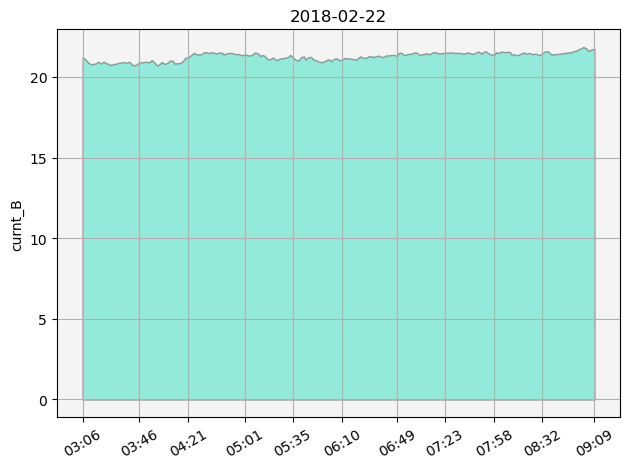

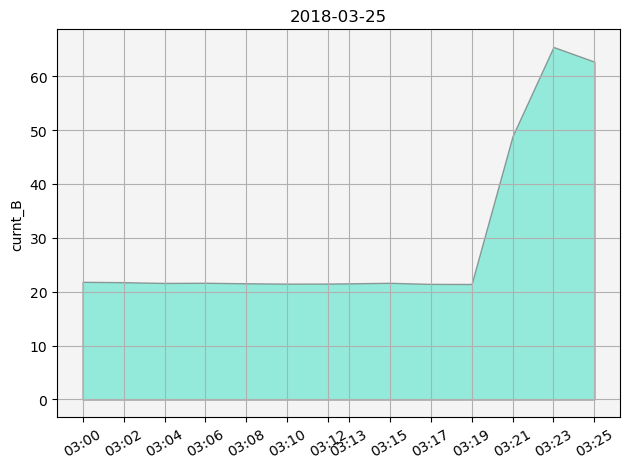

max_iteration:  11


/opt/miniconda3/envs/nilm/lib/python3.8/site-packages/sklearn/datasets/_samples_generator.py:1335: FutureWarning: The default value of data_transposed will change from True to False in version 1.3
  warnings.warn(


y=[ 2.44997877 -0.36521606]
 X.T=[[ 0.87473581 -0.48460011]
 [ 0.38815585  0.92159375]
 [ 0.98825271 -0.15282862]
 [ 0.99894086 -0.04601269]
 [ 0.97667346  0.21472996]]
 w=[ 0.3130677  -0.20515826  0.33367433  1.49407907  0.44386323]



ValueError: Found input variables with inconsistent numbers of samples: [5, 2]

In [2]:
wufang45 = Bump("data/WuFanZhuang-45-139040-values 20181001-20190214.csv")
wufang45.load_data()
wufang45.get_event(val=1, time=10)
wufang45.compute_features()
plot_ts_area(wufang45.events_monotype[0], 'curnt_B')
plot_ts_area(wufang45.events_other[0], 'curnt_B')
wufang45.kmeans_elbow()
wufang45.matching_pursuit()

Explained variance by component: [0.75854294 0.14506591]


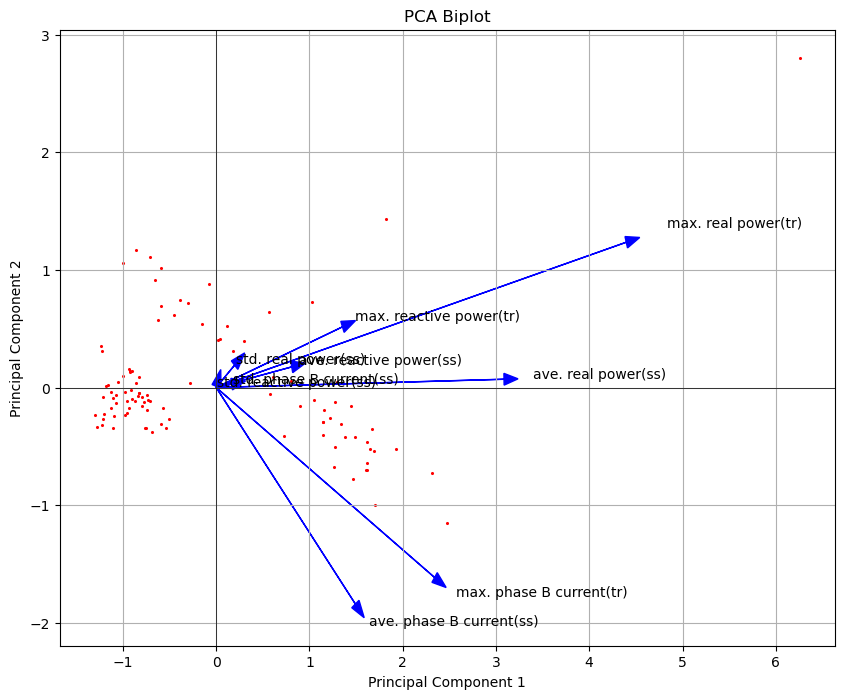

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

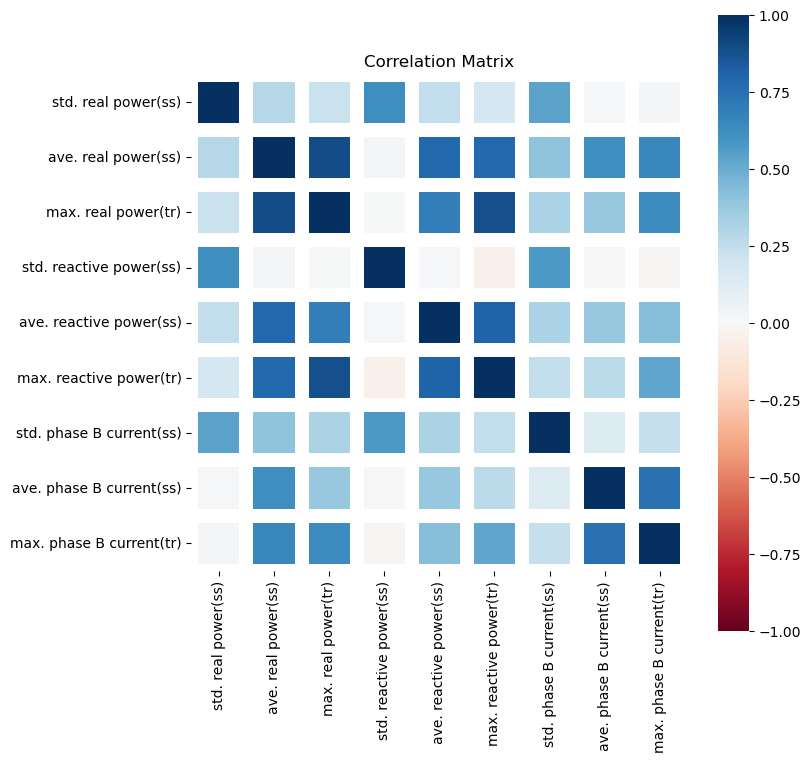

In [3]:
analyze_data(wufang45.feature)